In [1]:
import re
import pandas as pd
import datetime

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
building_md = pd.read_csv('building_metadata.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
weather_test = pd.read_csv("weather_test.csv")
weather_train = pd.read_csv("weather_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
building_md.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [4]:
building_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [5]:
building_md.site_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
building_md.head()


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [7]:
building_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [8]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


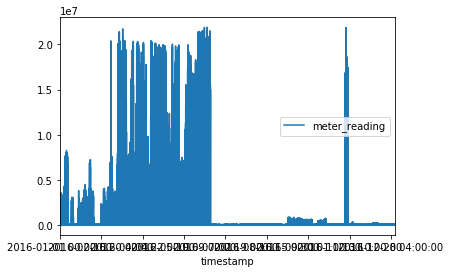

In [11]:
train.plot(x = "timestamp", y = "meter_reading")

In [12]:
train[train["meter_reading"]>20000000]

,building_id,meter,timestamp,meter_reading
3096856,1099,2,2016-02-27 20:00:00,20392200.0
3098934,1099,2,2016-02-27 21:00:00,20154200.0
3534117,1099,2,2016-03-07 13:00:00,20128200.0
3576101,1099,2,2016-03-08 09:00:00,20812000.0
3578205,1099,2,2016-03-08 10:00:00,21316400.0
...,...,...,...,...
9069340,1099,2,2016-06-16 06:00:00,20482500.0
9076373,1099,2,2016-06-16 09:00:00,20464600.0
17276974,1099,2,2016-11-09 10:00:00,21162700.0
17284060,1099,2,2016-11-09 13:00:00,21821700.0


In [13]:
train["meter"].unique()

array([0, 3, 1, 2])

In [14]:
meter0 = train[train["meter"] == 0]

In [15]:
meter0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12060910 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 460.1+ MB


In [16]:
meter1 = train[train["meter"] == 1]

In [17]:
meter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182440 entries, 172 to 20216049
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 159.5+ MB


In [18]:
meter2 = train[train["meter"] == 2]

In [19]:
meter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708713 entries, 894 to 20216093
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 103.3+ MB


In [20]:
meter3 = train[train["meter"] == 3]

In [21]:
meter3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264037 entries, 105 to 20215867
Data columns (total 4 columns):
building_id      1264037 non-null int64
meter            1264037 non-null int64
timestamp        1264037 non-null object
meter_reading    1264037 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.2+ MB


In [22]:
meter0_sample = meter0[::500]

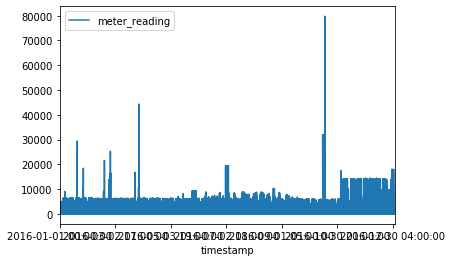

In [23]:
meter0.plot(x = "timestamp", y = "meter_reading")

There is a spike in the plot above. I will treat it as an outlier and delete the row from the original table, just in case.

In [3]:
train.drop(train[train['meter']==0][train['meter_reading']>70000].index.values)

/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [24]:
meter0_sample[meter0_sample["meter_reading"]>8000]    # are these outliers or not?

,building_id,meter,timestamp,meter_reading
19324740,799,0,2016-12-16 06:00:00,12670.5
19336553,799,0,2016-12-16 11:00:00,14090.8
19348365,799,0,2016-12-16 16:00:00,14090.8


In [25]:
meter0_sample[meter0_sample["meter_reading"]>8000]["timestamp"]

19324740    2016-12-16 06:00:00
19336553    2016-12-16 11:00:00
19348365    2016-12-16 16:00:00
Name: timestamp, dtype: object

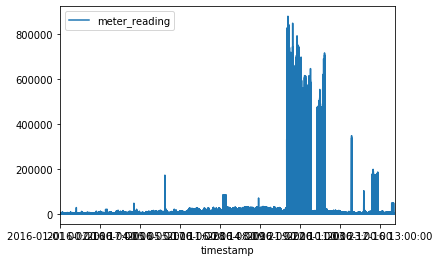

In [26]:
meter1.plot(x = "timestamp", y = "meter_reading")

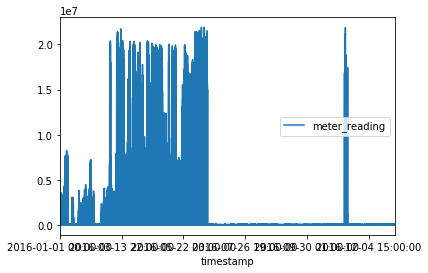

In [27]:
meter2.plot(x = "timestamp", y = "meter_reading")

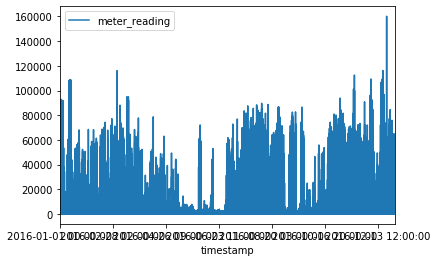

In [28]:
meter3.plot(x = "timestamp", y = "meter_reading")

Let's explore the weather-meter_reading correlations

In [90]:
train['site_id']= train.merge(building_md, on = "building_id", how = 'left')['site_id']

In [30]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 5 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
site_id          int64
dtypes: float64(1), int64(3), object(1)
memory usage: 771.2+ MB


In [91]:
train['air_temp'] = train.merge(weather_train, on =['site_id', 'timestamp'], how = 'left')['air_temperature']

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
site_id          int64
air_temp         float64
dtypes: float64(2), int64(3), object(1)
memory usage: 925.4+ MB


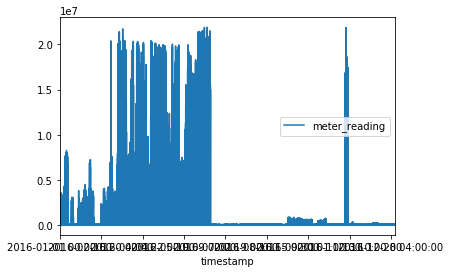

In [34]:
train.plot(x = "timestamp", y = "meter_reading")

Why this plot is uneven, let's look at the temperature

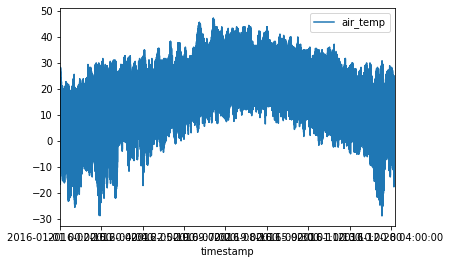

In [35]:
train.plot(x = "timestamp", y = "air_temp")

Temperature graph makes sense, but it does not explain the meter_reading graph

Let's look at distribution of meters in the table, maybe it will explain the shape of the graph

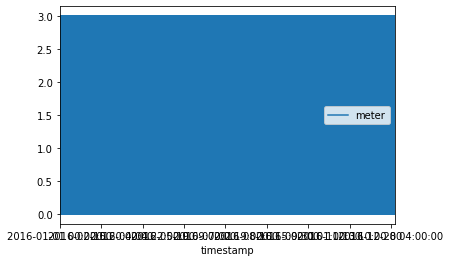

In [36]:
train.plot(x = "timestamp", y = "meter")

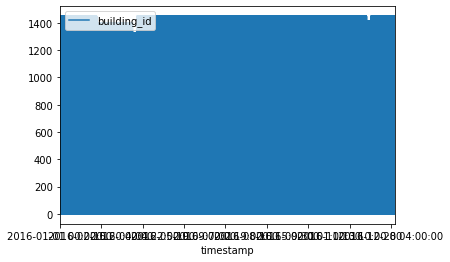

In [37]:
train.plot(x = "timestamp", y = "building_id")

Meter #s seem to be distributed evenly over the table, let's check site_ids

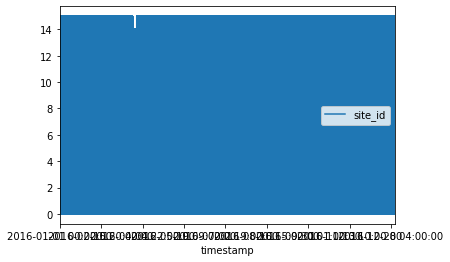

In [38]:
train.plot(x = "timestamp", y = "site_id")

Let's look at distribution of building ids

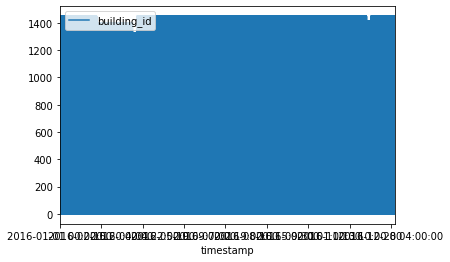

In [39]:
train.plot(x = "timestamp", y = "building_id")

This distribution doesn't provide an explanation either.
What we notice about the shape of the meter_reading distribution is that it resembles 
the shape of meter2 distribution. Let's explore meter2 table. Let's select meter2 rows again to preserve site_id and air_temp columns

Let's explore primary use column

In [92]:
train['primary_use'] = train.merge(building_md, on ='building_id', how = 'left')['primary_use']

In [61]:
train.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [62]:
meter2 = train[train['meter']==2]

In [63]:
meter2.primary_use.value_counts()

Education                        1136519
Office                            677872
Lodging/residential               363648
Entertainment/public assembly     242771
Public services                    83882
Healthcare                         77513
Manufacturing/industrial           33820
Food sales and service             17568
Services                           17568
Parking                            17568
Utility                            14944
Other                               8784
Warehouse/storage                   8784
Technology/science                  7472
Name: primary_use, dtype: int64

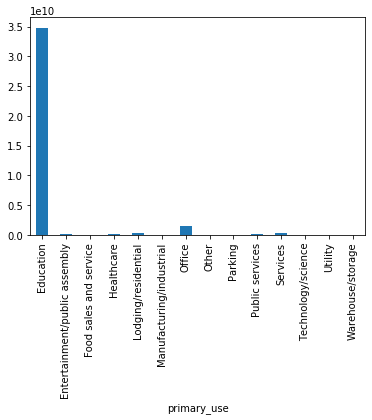

In [68]:
meter2.groupby('primary_use')['meter_reading'].sum().plot(kind= 'bar')

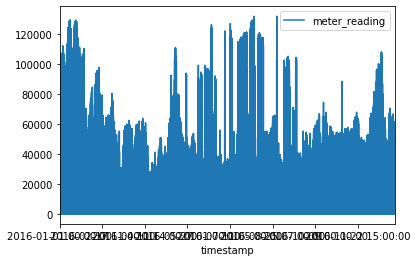

In [71]:
meter2[meter2['primary_use']!='Education'].plot(x = 'timestamp', y = 'meter_reading')

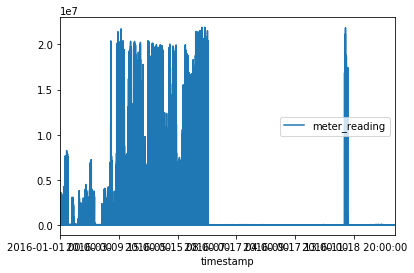

In [72]:
meter2[meter2['primary_use']=='Education'].plot(x='timestamp', y='meter_reading')

We figured out that Education buildings were the ones producing this meter_reading distribution

Now, lets see if there are any missing values in the train dataset. First we will download it again and exclude the outlier

In [4]:
train = pd.read_csv("train.csv")
train = train.drop(train[train['meter']==0][train['meter_reading']>70000].index.values)

/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [18]:
train_null =train.isnull()

In [20]:
train_null[train_null['building_id']==True]

,building_id,meter,timestamp,meter_reading


In [22]:
train_null[train_null['meter']==True]

,building_id,meter,timestamp,meter_reading


In [23]:
train_null[train_null['timestamp']==True]

,building_id,meter,timestamp,meter_reading


So, no missing data in the train table. 





Let's look at building_md

In [72]:
building_md_null = building_md.isnull()

In [73]:
building_md_null

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True
...,...,...,...,...,...,...
1444,False,False,False,False,False,True
1445,False,False,False,False,True,True
1446,False,False,False,False,False,True
1447,False,False,False,False,False,True


In [74]:
building_md_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null bool
building_id    1449 non-null bool
primary_use    1449 non-null bool
square_feet    1449 non-null bool
year_built     1449 non-null bool
floor_count    1449 non-null bool
dtypes: bool(6)
memory usage: 8.6 KB


In [75]:
building_md_null[building_md_null['site_id'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [76]:
building_md_null[building_md_null['building_id'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [77]:
building_md_null[building_md_null['primary_use'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [78]:
building_md_null[building_md_null['square_feet'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [79]:
building_md_null[building_md_null['year_built'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
105,False,False,False,False,True,False
106,False,False,False,False,True,False
112,False,False,False,False,True,False
116,False,False,False,False,True,False
127,False,False,False,False,True,False
...,...,...,...,...,...,...
1357,False,False,False,False,True,True
1370,False,False,False,False,True,True
1395,False,False,False,False,True,True
1421,False,False,False,False,True,True


In [80]:
building_md_null[building_md_null['year_built'] == True].count()  # 774 records don't supply "year_built" value

site_id        774
building_id    774
primary_use    774
square_feet    774
year_built     774
floor_count    774
dtype: int64

In [81]:
building_md_null[building_md_null['floor_count'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True
...,...,...,...,...,...,...
1444,False,False,False,False,False,True
1445,False,False,False,False,True,True
1446,False,False,False,False,False,True
1447,False,False,False,False,False,True


In [82]:
building_md_null[building_md_null['floor_count'] == True].count()  # majority of buildings don't have floor counts

site_id        1094
building_id    1094
primary_use    1094
square_feet    1094
year_built     1094
floor_count    1094
dtype: int64

Only year_build and floor_count columns have missing data. I will drop them for the purpose of training. 

In [27]:
building_md_clean = building_md[['site_id', 'building_id', 'primary_use', 'square_feet']]

In [28]:
building_md_clean.to_csv('building_metadata_clean.csv', index=False)

Lets explore the weather_train data

In [5]:
weather_train_null = weather_train.isnull()

In [6]:
weather_train_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null bool
timestamp             139773 non-null bool
air_temperature       139773 non-null bool
cloud_coverage        139773 non-null bool
dew_temperature       139773 non-null bool
precip_depth_1_hr     139773 non-null bool
sea_level_pressure    139773 non-null bool
wind_direction        139773 non-null bool
wind_speed            139773 non-null bool
dtypes: bool(9)
memory usage: 1.2 MB


In [8]:
weather_train_null[weather_train_null['site_id']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [11]:
weather_train_null[weather_train_null['timestamp']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [10]:
weather_train_null[weather_train_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,False,False,True,True,True,False,True,False,False
369,False,False,True,False,True,False,True,False,False
370,False,False,True,False,True,False,True,False,False
15763,False,False,True,True,True,True,True,False,False
22349,False,False,True,True,True,False,True,True,True
27393,False,False,True,False,True,False,True,True,True
30910,False,False,True,True,True,False,True,True,True
30911,False,False,True,True,True,False,True,True,True
30914,False,False,True,False,True,True,True,True,True
50108,False,False,True,True,True,True,True,False,False


In [119]:
weather_train[weather_train_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,0,2016-01-16 08:00:00,NaN,NaN,NaN,0.0,NaN,180.0,1.5
369,0,2016-01-16 09:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
370,0,2016-01-16 10:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
15763,1,2016-10-18 13:00:00,NaN,NaN,NaN,NaN,NaN,290.0,6.2
22349,2,2016-07-19 02:00:00,NaN,NaN,NaN,86.0,NaN,NaN,NaN
27393,3,2016-02-14 07:00:00,NaN,0.0,NaN,0.0,NaN,NaN,NaN
30910,3,2016-07-09 20:00:00,NaN,NaN,NaN,38.0,NaN,NaN,NaN
30911,3,2016-07-09 21:00:00,NaN,NaN,NaN,8.0,NaN,NaN,NaN
30914,3,2016-07-10 00:00:00,NaN,4.0,NaN,NaN,NaN,NaN,NaN
50108,5,2016-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,310.0,4.6


In [97]:
weather_train_null[weather_train_null['cloud_coverage']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,False,False,False,True,False,False,False,False,False
5,False,False,False,True,False,False,True,False,False
7,False,False,False,True,False,False,False,False,False
8,False,False,False,True,False,False,False,False,False
9,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
139767,False,False,False,True,False,True,False,False,False
139768,False,False,False,True,False,True,True,False,False
139770,False,False,False,True,False,True,False,False,False
139771,False,False,False,True,False,True,False,False,False


In [98]:
weather_train_null[weather_train_null['dew_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,False,False,True,True,True,False,True,False,False
369,False,False,True,False,True,False,True,False,False
370,False,False,True,False,True,False,True,False,False
15763,False,False,True,True,True,True,True,False,False
22349,False,False,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...
115739,False,False,True,True,True,False,True,True,True
126458,False,False,True,True,True,False,True,True,True
136656,False,False,False,False,True,True,False,False,False
137297,False,False,False,True,True,True,False,False,False


In [100]:
weather_train_null[weather_train_null['precip_depth_1_hr']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,False,False,False,False,False,True,False,False,False
8784,False,False,False,True,False,True,False,False,False
8785,False,False,False,False,False,True,False,False,False
8786,False,False,False,False,False,True,False,False,False
8787,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...
139767,False,False,False,True,False,True,False,False,False
139768,False,False,False,True,False,True,True,False,False
139769,False,False,False,False,False,True,False,False,False
139770,False,False,False,True,False,True,False,False,False


In [101]:
weather_train_null[weather_train_null['sea_level_pressure']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
5,False,False,False,True,False,False,True,False,False
26,False,False,False,True,False,False,True,False,False
75,False,False,False,True,False,False,True,False,False
171,False,False,False,True,False,False,True,False,False
187,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
139559,False,False,False,True,False,True,True,False,False
139560,False,False,False,True,False,True,True,False,False
139561,False,False,False,True,False,True,True,False,False
139562,False,False,False,True,False,True,True,False,False


In [102]:
weather_train_null[weather_train_null['wind_direction']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
163,False,False,False,False,False,False,False,True,False
164,False,False,False,True,False,False,False,True,False
256,False,False,False,False,False,False,False,True,False
428,False,False,False,True,False,False,False,True,False
573,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
138949,False,False,False,True,False,False,False,True,False
139127,False,False,False,True,False,True,False,True,False
139151,False,False,False,True,False,True,False,True,False
139158,False,False,False,False,False,True,False,True,False


In [103]:
weather_train_null[weather_train_null['wind_speed']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
21143,False,False,False,False,False,False,False,True,True
22349,False,False,True,True,True,False,True,True,True
22614,False,False,False,True,False,False,False,False,True
22896,False,False,False,True,False,False,False,True,True
23314,False,False,False,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...
137333,False,False,False,False,False,True,False,True,True
137338,False,False,False,False,False,True,False,True,True
137849,False,False,False,False,False,True,False,True,True
138046,False,False,False,False,False,True,True,True,True


We can see that there is a lot of empty data in weather_train dataset
Lets remove all incomplete data. Lets start with cloud-coverage

In [7]:
weather_train_new = weather_train[weather_train_null['air_temperature']==False][weather_train_null['cloud_coverage']==False][weather_train_null['dew_temperature']==False][weather_train_null['precip_depth_1_hr']==False][weather_train_null['sea_level_pressure']==False][weather_train_null['wind_direction']==False][weather_train_null['wind_speed']==False]




/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [8]:
weather_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48780 entries, 2 to 139476
Data columns (total 9 columns):
site_id               48780 non-null int64
timestamp             48780 non-null object
air_temperature       48780 non-null float64
cloud_coverage        48780 non-null float64
dew_temperature       48780 non-null float64
precip_depth_1_hr     48780 non-null float64
sea_level_pressure    48780 non-null float64
wind_direction        48780 non-null float64
wind_speed            48780 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.7+ MB


Check to make sure that there is no more missing values in weather_train_new

In [18]:
weather_train_new_null = weather_train_new.isnull()

In [19]:
weather_train_new_null[weather_train_new_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [20]:
weather_train_new_null[weather_train_new_null['cloud_coverage']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [21]:
weather_train_new_null[weather_train_new_null['dew_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [22]:
weather_train_new_null[weather_train_new_null['precip_depth_1_hr']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [23]:
weather_train_new_null[weather_train_new_null['sea_level_pressure']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [24]:
weather_train_new_null[weather_train_new_null['wind_direction']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [25]:
weather_train_new_null[weather_train_new_null['wind_speed']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


All clear, no more missing data





In [9]:
weather_train_new.to_csv('weather_train_clean.cvs', index= False)

In [9]:
weather_train_removed = weather_train[weather_train_null['air_temperature']|weather_train_null['cloud_coverage']|weather_train_null['dew_temperature']|weather_train_null['precip_depth_1_hr']|weather_train_null['sea_level_pressure']|weather_train_null['wind_direction']|weather_train_null['wind_speed']==True]



In [13]:
weather_train_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90993 entries, 0 to 139772
Data columns (total 9 columns):
site_id               90993 non-null int64
timestamp             90993 non-null object
air_temperature       90938 non-null float64
cloud_coverage        21820 non-null float64
dew_temperature       90880 non-null float64
precip_depth_1_hr     40704 non-null float64
sea_level_pressure    80375 non-null float64
wind_direction        84725 non-null float64
wind_speed            90689 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 6.9+ MB


In [14]:
90993+48780  #Quick check of empty and non-empty add up. Indeed the total number of rows is 139773

139773

In [10]:
train_merged = train

In [11]:
train_merged['site_id']= train_merged.merge(building_md, on = "building_id", how = 'left')['site_id']

In [18]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [14]:
train_new= train_merged.merge(weather_train_new, on = ["site_id", "timestamp"], how = 'inner')

In [16]:
train_clean = train_new[['building_id', 'meter', 'timestamp', 'meter_reading']]

In [17]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8955946 entries, 0 to 8955945
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 341.6+ MB


In [26]:
train_clean.to_csv('train_clean.cvs', index= False)

The dataset is very large, let's select and explore a random sample.

In [91]:
train_clean = pd.read_csv('train_clean.cvs')

In [8]:
train_sample1 = train_clean.sample(15000)

In [10]:
train_sample1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 7690044 to 2959963
Data columns (total 4 columns):
building_id      15000 non-null int64
meter            15000 non-null int64
timestamp        15000 non-null object
meter_reading    15000 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 585.9+ KB


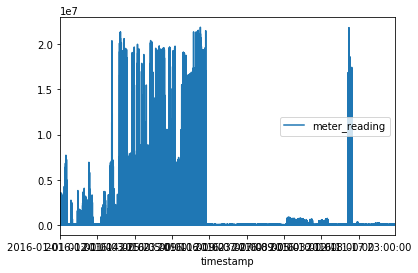

In [12]:
train_clean.plot(x= 'timestamp', y= 'meter_reading')

In [16]:
train_clean['timestamp'].min()

'2016-01-01 01:00:00'

In [15]:
train_clean['timestamp'].max()

'2016-12-31 23:00:00'

In [17]:
train_sample1['timestamp'].min()

'2016-01-01 01:00:00'

In [18]:
train_sample1['timestamp'].max()

'2016-12-31 23:00:00'

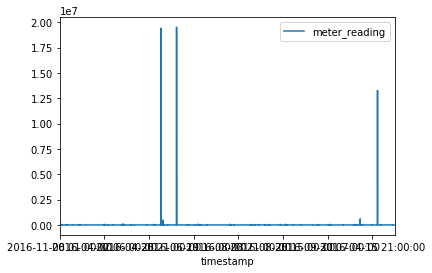

In [32]:
train_sample1.plot(x= 'timestamp', y= 'meter_reading')

Lets try a larger table

In [92]:
train_sample2 = train_clean.sample(50000)

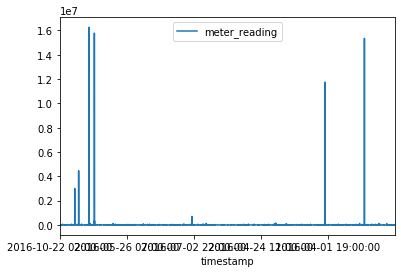

In [93]:
train_sample2.plot(x= 'timestamp', y= 'meter_reading')

Even larger

In [102]:
train_sample3 = train_clean.sample(100000)

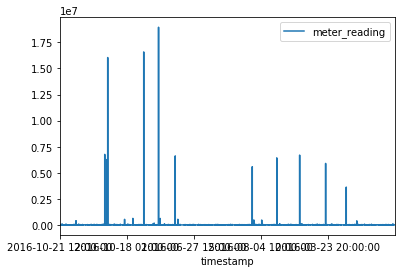

In [106]:
train_sample3.plot(x= 'timestamp', y= 'meter_reading')

In [112]:
train_sample4 = train_clean.sample(100000)

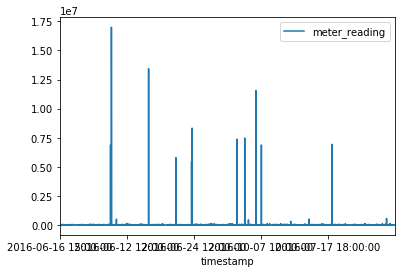

In [113]:
train_sample4.plot(x= 'timestamp', y= 'meter_reading')

Lets write the train sample and the verification sample into csv files

In [114]:
train_sample3.to_csv('train_train.csv', index= False)

In [115]:
train_sample4.to_csv('train_verify.csv', index= False)